### Notebook based on:
https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro

# Imports

In [24]:
########################## EDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

########################## Preprecessing
import spacy
import time
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

########################## Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import MultinomialNB
from sklearn.naive_bayes  import BernoulliNB
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier

########################## Machine Learning Evaluation
from sklearn.metrics         import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


pd.set_option('max_colwidth', -1)

# Read data

In [ ]:
##### DOWNLOAD DATASET. ONLY IN COLAB !!!
#!wget -P ./data "https://raw.githubusercontent.com/SaturdaysAI-Murcia/machine-learning/master/4. NLP/data/movieReviews_trainLabel.tsv"

In [2]:
df = pd.read_csv("data/movieReviews_trainLabel.tsv", sep="\t", index_col="id")
print(df.shape)
df.head(1)

(25000, 2)


,sentiment,review
id,,
5814_8,1,"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally starts is only on for 20 minutes or so excluding the Smooth Criminal sequence and Joe Pesci is convincing as a psychopathic all powerful drug lord. Why he wants MJ dead so bad is beyond me. Because MJ overheard his plans? Nah, Joe Pesci's character ranted that he wanted people to know it is he who is supplying drugs etc so i dunno, maybe he just hates MJ's music.<br /><br />Lots of cool things in this like MJ turning into a car and a robot and the whole Speed Demon sequence. Also, the director must have had the patience of a saint when it came to filming the kiddy Bad sequence as usually directors hate working with one kid let alone a whole bunch of them performing a complex dance scene.<br /><br />Bottom line, this movie is for people who like MJ on one level or another (which i think is most people). If not, then stay away. It does try and give off a wholesome message and ironically MJ's bestest buddy in this movie is a girl! Michael Jackson is truly one of the most talented people ever to grace this planet but is he guilty? Well, with all the attention i've gave this subject....hmmm well i don't know because people can be different behind closed doors, i know this for a fact. He is either an extremely nice but stupid guy or one of the most sickest liars. I hope he is not the latter."


# EDA
### Target

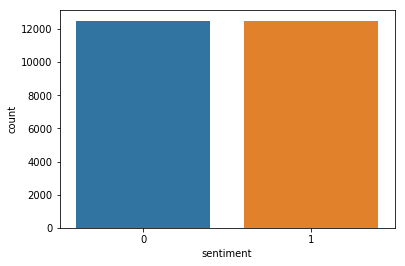

In [3]:
sns.countplot(df['sentiment']);

### Text

In [4]:
positive = df[df['sentiment']==1]['review']
negative = df[df['sentiment']==0]['review']

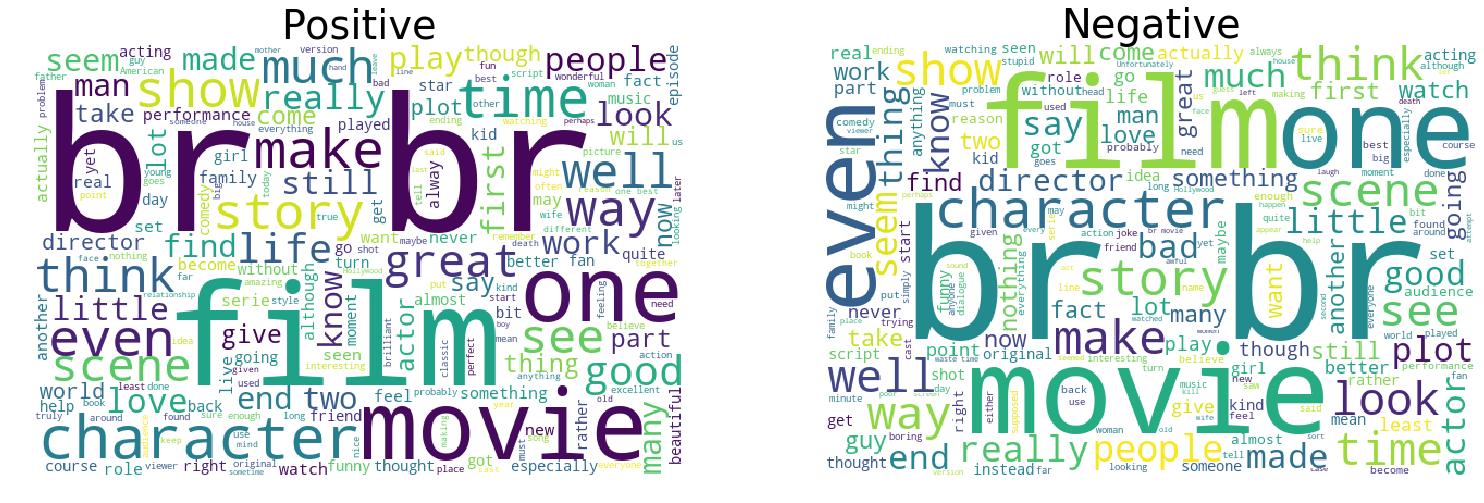

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive', fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative',fontsize=40);

# NLP Preprocessing

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the basic text pre-processing techniques includes:

- Make text all **lower case** or **upper case** so that the algorithm does not treat the same words in different cases as different
- **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values, common non-sensical text (/n)
- **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
- **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

### More data cleaning steps after tokenization:
- **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
- **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
- **Parts of speech** tagging
- Create **bi-grams** or tri-grams And more...

However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand. Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled: [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial) that summarizes how much preprocessing you should be performing on your text data:

# <center> Toy Example

In [ ]:
texts = [
    'Hola esto es una frase',
    'Hola esto es otra frase',
    'Hola hola hola, no vengas sola'
]

### Bag Of Words (BOW)

In [34]:
bow = CountVectorizer()
texts_bow = bow.fit_transform(texts)
tokens = bow.get_feature_names()
pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,es,esto,frase,hola,no,otra,sola,una,vengas
Text 1,1,1,1,1,0,0,0,1,0
Text 2,1,1,1,1,0,1,0,0,0
Text 3,0,0,0,3,1,0,1,0,1


In [41]:
bow = CountVectorizer(ngram_range=(2, 2))
texts_bow = bow.fit_transform(texts)
tokens = bow.get_feature_names()
pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,es otra,es una,esto es,hola esto,hola hola,hola no,no vengas,otra frase,una frase,vengas sola
Text 1,0,1,1,1,0,0,0,0,1,0
Text 2,1,0,1,1,0,0,0,1,0,0
Text 3,0,0,0,0,2,1,1,0,0,1


### TFIDF
A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency**: is a scoring of the frequency of the word in the current document.
- **Inverse Document Frequency**: is a scoring of how rare the word is across documents.

In [39]:
tfidf = TfidfVectorizer()
texts_tfidf = tfidf.fit_transform(texts)
tokens = tfidf.get_feature_names()
pd.DataFrame(data=texts_tfidf.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,es,esto,frase,hola,no,otra,sola,una,vengas
Text 1,0.433067,0.433067,0.433067,0.336315,0.000000,0.000000,0.000000,0.569431,0.000000
Text 2,0.433067,0.433067,0.433067,0.336315,0.000000,0.569431,0.000000,0.000000,0.000000
Text 3,0.000000,0.000000,0.000000,0.715092,0.403585,0.000000,0.403585,0.000000,0.403585


# <center> Extract Features

### Bag Of Words 1-gram

In [6]:
bow_1gram = CountVectorizer()
text_bow_1gram = bow_1gram.fit_transform(df['review'])

### Bag Of Words 1-2-grams

In [7]:
bow_2grams = CountVectorizer(ngram_range=(1, 2))
text_bow_2grams = bow_2grams.fit_transform(df['review'])

### TFIDF 1-gram

In [9]:
tfidf_1gram      = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 1))
text_tfidf_1gram = tfidf_1gram.fit_transform(df['review'])

### TFIDF 1-2-grams

In [10]:
tfidf_2grams      = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
text_tfidf_2grams = tfidf_2grams.fit_transform(df['review'])

In [20]:
data = [
    ("BOW 1gram",   text_bow_1gram),
    ("BOW 2grams",  text_bow_2grams),
    ("TFIDF 1gram", text_tfidf_1gram),
    ("TFIDF 2grams",text_tfidf_2grams)
]

print("BOW 1gram   ", text_bow_1gram.shape)
print("BOW 2grams  ", text_bow_2grams.shape)
print("TFIDF 1gram ", text_tfidf_1gram.shape)
print("TFIDF 2grams", text_tfidf_2grams.shape)

BOW 1gram    (25000, 74849)
BOW 2grams   (25000, 1513832)
TFIDF 1gram  (25000, 44772)
TFIDF 2grams (25000, 438625)


# <center> ML Models

## Naive Bayes (<1 segundo)

In [25]:
for name, d in data:
    x_train, x_test, y_train, y_test = train_test_split(d, df["sentiment"],
                                                    test_size=0.2, shuffle=True, random_state=0)
    model = MultinomialNB()
    ts = time.time()
    model.fit(x_train, y_train)
    t = time.time() - ts
    a = accuracy_score(y_test, model.predict(x_test))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8636 	Time:	 0.02378392219543457
BOW 2grams 	Accuracy:	 0.8924 	Time:	 0.18772506713867188
TFIDF 1gram 	Accuracy:	 0.876 	Time:	 0.02291703224182129
TFIDF 2grams 	Accuracy:	 0.8988 	Time:	 0.10370206832885742


## Logistic Regression (3+30+2+8 segundos)

In [26]:
for name, d in data:
    x_train, x_test, y_train, y_test = train_test_split(d, df["sentiment"],
                                                    test_size=0.2, shuffle=True, random_state=0)
    model = LogisticRegression(n_jobs=-1)
    ts = time.time()
    model.fit(x_train, y_train)
    t = time.time() - ts
    a = accuracy_score(y_test, model.predict(x_test))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.883 	Time:	 3.3636088371276855
BOW 2grams 	Accuracy:	 0.8984 	Time:	 31.007741928100586
TFIDF 1gram 	Accuracy:	 0.8928 	Time:	 1.831233024597168
TFIDF 2grams 	Accuracy:	 0.9006 	Time:	 8.384637117385864


## Random Forest (10+90+6+22 segundos)

In [28]:
for name, d in data:
    x_train, x_test, y_train, y_test = train_test_split(d, df["sentiment"],
                                                    test_size=0.2, shuffle=True, random_state=0)
    model = RandomForestClassifier(n_jobs=-1)
    ts = time.time()
    model.fit(x_train, y_train)
    t = time.time() - ts
    a = accuracy_score(y_test, model.predict(x_test))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8526 	Time:	 10.628031015396118
BOW 2grams 	Accuracy:	 0.8616 	Time:	 90.25301718711853
TFIDF 1gram 	Accuracy:	 0.8502 	Time:	 6.878548860549927
TFIDF 2grams 	Accuracy:	 0.8584 	Time:	 22.39651393890381
